 **`Anna Meleshko 319346045`**



 **`Yonatan Blum 308131333`**

---



![alt text](http://www.global-wheat.com/wp-content/uploads/2019/11/temporary_gwd_logo-2.png)

---



![alt text](https://www.morningagclips.com/wp-content/uploads/2019/05/4764724998_21d90eaebb_z.jpg)

# **About this Competition**

---



In this competition, we asked to detect wheat heads from images of wheat plants from all around the world. These images are used to estimate the density and size of wheat heads in different varieties, so Farmers can use the data to assess health and maturity when making management decisions in their fields.
However, accurate wheat head detection in outdoor field images can be visually challenging, There is often overlap of dense wheat plants, and the wind can blur the photographs. Additionally, appearances vary due to maturity, color, genotype, and head orientation.
To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions, and we will use more than 3000 images from Europe and Noeth America.


---



# **GWD Dataset** 

* Files
    * **train.csv** - training data
    * **train** - 3422 train images of wheat
    * **test.zip** - 10 test images of wheat(its a small part of 1000 test image that kaggle going to use for the score).
    * **sample_submission.csv** - a sample submission file in the correct format, to show us how to make the submission.
* Csv file include: 
    * **image_id** - uniqe number of each image.
    * **width, height** - width and height of the images
    * **bbox** - bounding box, formatted as a python-style list of [xmin, ymin, width, height] (COCO format).
    * source - source of the image , there few types of the imaeges, we will not use this column.


---



## **Imports & Installs**

---



In [ ]:
!pip install -q -U git+https://github.com/albumentations-team/albumentations
!pip install -q "torch==1.4" "torchvision==0.5.0"
!pip install -q torch_optimizer
!pip install -q ensemble-boxes
!pip install -q timm
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch
!pip install -q effdet
!pip install -q omegaconf
!pip install -q effdet omegaconf
!wget https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d5-ef44aea8.pth

In [ ]:
import os
import cv2
import glob
import copy 
import torch
import random
import torchvision 
import numpy as np
import pandas as pd
import imgaug as ia
%matplotlib inline
from numba import jit
import albumentations as A
from tqdm.auto import tqdm
import torch.optim as optim
from ensemble_boxes import *
from google.colab import drive
from collections import Counter
import torch_optimizer as optim1
from torchvision import transforms
from imgaug import augmenters as iaa
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import torch.optim.lr_scheduler as lr_scheduler 
from torch.utils.data import Dataset,DataLoader
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import train_test_split
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

SEED = 44

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

drive.mount('/content/gdrive')


# Reading And Loading Data

---

There are 2 formats :
* pascal_voc: min/max coordinates [x_min, y_min, x_max, y_max]
* coco: width/height instead of maxes [x_min, y_min, width, height]

in our dataset we will use the pascal_voc format which worked good for fasterRCNN model and EfficientDet model.

In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/Global Wheat Detection/train.csv") 
train_path = "/content/gdrive/My Drive/Global Wheat Detection/train"

In [ ]:
train.head()

In [ ]:
bboxes = np.stack(train['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x_min', 'y_min', 'width', 'height']):
    train[column] = bboxes[:,i]
    
train.drop(columns=['bbox'], inplace=True)
train.drop(columns=['source'], inplace=True)

In [ ]:
train.head(5)

,image_id,width,height,x_min,y_min
0,b6ab77fd7,56.0,36.0,834.0,222.0
1,b6ab77fd7,130.0,58.0,226.0,548.0
2,b6ab77fd7,74.0,160.0,377.0,504.0
3,b6ab77fd7,109.0,107.0,834.0,95.0
4,b6ab77fd7,124.0,117.0,26.0,144.0


# Check The Image Extantion

---



In [ ]:
def check_file_type(folder_path):
    extension_type = []
    file_list = os.listdir(folder_path)
    for file in file_list:
        extension_type.append(file.rsplit(".", 1)[1].lower())
    print(Counter(extension_type).keys())
    print(Counter(extension_type).values())
    
check_file_type(train_path)

dict_keys(['jpg'])
dict_values([3422])


# Check Image Size

---



In [ ]:
def check_image_size(folder_path):
    total_img_list = glob.glob(f'{folder_path}/*.jpg')
    counter = 0
    for image in tqdm(total_img_list, desc = "Check image size in progress"):
        try:
            img = cv2.imread(image)
            height, width = img.shape[1], img.shape[0]
            if not (height == 1024 and width == 1024):
                counter = counter + 1
        except:
            print("This {} have a problem.".format(image))
    return counter 
check_image_size(train_path)


0

# Plot Random Wheat Images

---



In [ ]:
def plot_random_images(train_path, train_csv):
    image_ids_lst = list(train_csv['image_id'])
    plt.figure(figsize = (30,15))
    for idx in range(8):
        plt.subplot(2,4,idx +1)
        choose_random_image = np.random.choice(image_ids_lst,1)
        image = cv2.imread(f'{train_path}/{choose_random_image[0]}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        plt.imshow(image)
        plt.axis('off')
    plt.show()
plot_random_images(train_path, train)

Output hidden; open in https://colab.research.google.com to view.

# Plot Random Images With Boxes

---



In [ ]:
def get_box(image_id, df, col, color='white'):
    bboxes = df[df['image_id'] == image_id]
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes['x_min'].iloc[i], bboxes['y_min'].iloc[i]),
            bboxes['width'].iloc[i], 
            bboxes['height'].iloc[i], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')
        # Add the patch to the Axes
        col.add_patch(rect)

In [ ]:
def plot_random_images_with_boxes(train_path, train_csv):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
    count=0
    for row in ax:
        for col in row:
            image_ids_lst = list(train_csv['image_id'])
            choose_random_image = np.random.choice(image_ids_lst,1)
            img_id = choose_random_image[0]
            img = cv2.imread(f'{train_path}/{img_id}.jpg', cv2.IMREAD_COLOR)
            col.grid(False)
            col.set_xticks([])
            col.set_yticks([])
            get_box(img_id, train_csv, col, color='red')
            col.imshow(img)
            count += 1
    plt.show()

plot_random_images_with_boxes(train_path, train)    

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            # A.Blur(p=0.4), 
            # A.GaussianBlur(p=0.6),
            # A.RandomSunFlare(p= 0.8, flare_roi= (0.3, 0.3, 0.5, 0.7), num_flare_circles_lower=2, num_flare_circles_upper=5,src_radius=50),
            A.ToGray(p=0.2),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.6),
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
            A.Cutout(num_holes=8, max_h_size=20, max_w_size=20, p=0.8),
            ToTensorV2(p=1.0),

In [ ]:
def get_bbox(bboxes, col, color='white', bbox_format='pascal_voc'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        if bbox_format == 'pascal_voc':
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2] - bboxes[i][0], 
                bboxes[i][3] - bboxes[i][1], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')
        else:
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2], 
                bboxes[i][3], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

# Augmantations

---



Data plays a central role, as the performance of the deep neural network heavily depends on the amount and quality of the training data. To compensate the insufficient training data, data augmentation provides an effective alternative, which we call ”data augmentation”. The direct motivation for data augmentation is to overcome the limitation of existing data. It is a technology to enlarge the data size of training or testing by transforming collected real samples or simulated virtual samples. Deep learning strongly relies on large and complex training sets to generalize well in unconstrained settings. Collecting and labeling a large quantity of real samples is widely recognized as laborious, expensive and error-prone. Existing datasets are still lack of variations comparing to the samples in the real world.

In [ ]:
train["x_max"] = train.apply(lambda col: col.x_min + col.width, axis=1)
train["y_max"] = train.apply(lambda col: col.y_min + col.height, axis = 1)
pascal_voc_boxes = train[train['image_id'] == image_id][['x_min', 'y_min', 'x_max', 'y_max']].astype(np.int32).values
labels = np.ones((len(pascal_voc_boxes), ))

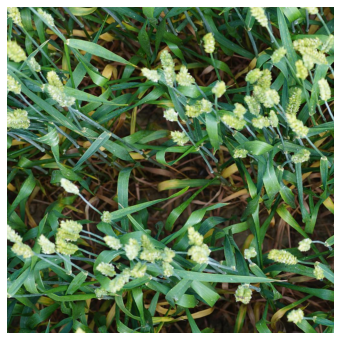

In [ ]:
image_id = 'c14c1e300'
image = cv2.imread(f'{train_path}/{image_id}.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
plt.figure(figsize = (6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()


## Blur -

---


### add blur to the image, big value of bluring can destroy the image and add too much blur ,so it will be diffcult to recognize the wheat heads.



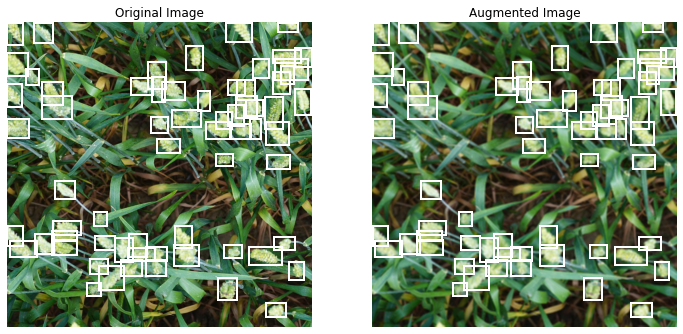

In [ ]:
aug = A.Compose([
        A.Blur((5,7), p=1),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def apply_aug_on_image(aug, image):
    aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    get_bbox(pascal_voc_boxes, ax[0], color='white')
    ax[0].title.set_text('Original Image')
    ax[0].imshow(image)
    ax[0].axis('off')
    get_bbox(aug_result['bboxes'], ax[1], color='white')
    ax[1].title.set_text('Augmented Image')
    ax[1].imshow(aug_result['image'])
    ax[1].axis('off')
    plt.show()


apply_aug_on_image(aug, image)

## HueSaturationValue

---
Big values for hue and saturation limits can destroy the data.


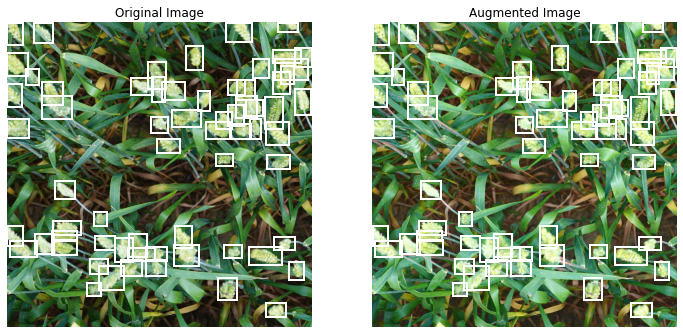

In [ ]:
aug = A.Compose([
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=1),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

apply_aug_on_image(aug, image)

## Random Brightness Contrast

---



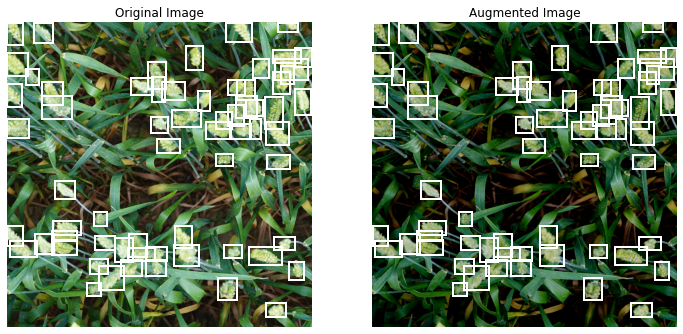

In [ ]:
aug = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=1),
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

apply_aug_on_image(aug, image)

## Random Sun Flare

---



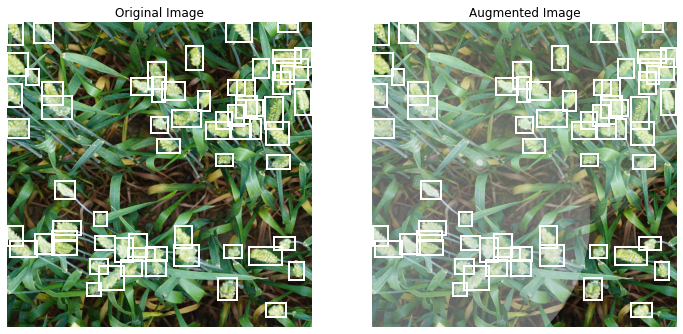

In [ ]:
aug = A.Compose([
    A.RandomSunFlare(p= 1, flare_roi= (0.3, 0.3, 0.5, 0.7), num_flare_circles_lower=3, num_flare_circles_upper=5,src_radius=60),
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

apply_aug_on_image(aug, image)

## HorizontalFlip
---
Albumantaion have in their augmantations a paramater that called 'bbox_params' which makes the boxes in the images move together with the augmantations.





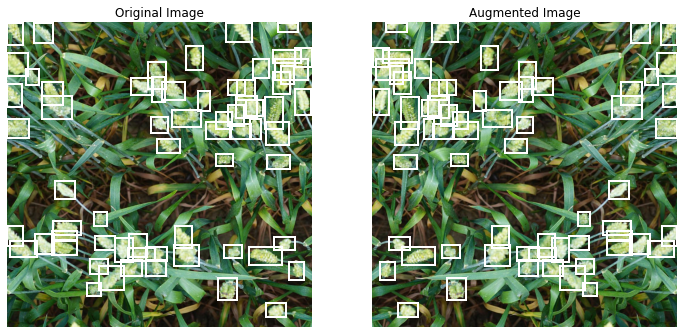

In [ ]:
aug = A.Compose([
    A.HorizontalFlip(p=1),
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

apply_aug_on_image(aug, image)

## Cut out - 


---
like drop out of imgaug library, drops parts of the images by setting max size of height and width (box size that drops out). 


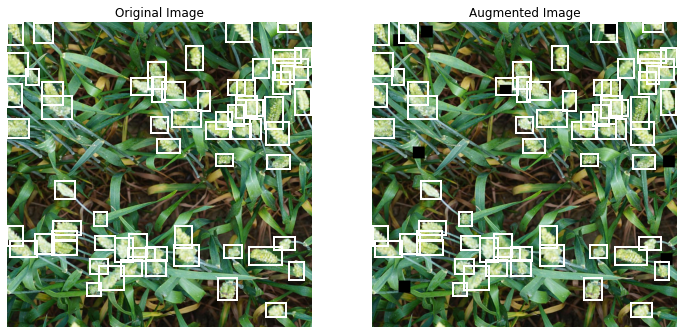

In [ ]:
aug = A.Compose([
    A.Cutout(num_holes=8, max_h_size=40, max_w_size=40, p=1),
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

apply_aug_on_image(aug, image)

## Cutmix Augmantaion - 


---


After we tried to train our dataset with all the augmantation above, we tried this augmantation and found that its imporved our training, and prevent it from get overfit, beacuse its added more data to the training and make the model more difficult to learn due to the new data. 
here is link to the medium paper which demonstrate how this augmanation work.
in sum this augmantation takes patches then cuted and pasted among training images where interestingly the ground truth labels are also mixed proportionally to the area of the patches.

[https://medium.com/depurr/cutmix-augmentation-in-python-bf099a97afac](https://medium.com/depurr/cutmix-augmentation-in-python-bf099a97afac)

![alt text](https://miro.medium.com/max/605/0*K4VIbGwSk96OowVM.png)

## [Training] - For training we used three models:


---


1. FasterRCNN
2. EfficientDet
3. Detectron2 

which for each one of then we have a notebook that demonstarte how we use those models, and the arichetcture of each model.


# FasterRCNN -
 [link to fasterRCNN notebook](https://colab.research.google.com/drive/1Z8wGEeR-VEi57S94e1apNnAGqFa_s2xl?authuser=1#scrollTo=dhEtBaj8D3D9)
 
---
With FasterRCNN we use 3 Backbones:
* ResNet50
* ResNet101
* ResNet152

1. we trained resnet50 with 60 epochs, Radam optimizer, and with the augmantations that we explained before, we got an score of : 0.5136, and after added the WBF over TTA techniqe we improved our score to 0.6877.

2. when we trained resnet101 with 33 epochs ,adamW optimizer and TTA/WBF we got the score of:  0.6990

3. when we trained the model on resnet152, the predicitions looked very good, we didnt submit it, but when me made an ensemble we sae that its improved our results.

we still were not satisfied so we tried another model which we saw that giving good results on kaggle: **efficientDet** 


# EfficientDet -

[link to efficentDet notebook](https://colab.research.google.com/drive/1Zbk-6sS5vlxETXITxGN8kvVshEfJjo3i?authuser=1#scrollTo=sG-WhqxVg-kb)

---


We efficientDet we tried 2 models:
* efficientDet - D5
* efficientDet - D7

The Results of effDet D5 on kaggle were : 0.6697
and on effDet D7 : 0.6584

After that we tried to add TTA/WBF and its improved our results to :
effDet D7 :0.6826

still it wasnt enough for us so we decided to try another model: **Detectron2**



# Detectron2 

[link to detectron notebook](https://colab.research.google.com/drive/1w7y_WplqDyJrDtJbpp4t0hHJFpmyLSNO#scrollTo=Z5MwqbyQH6Ii)

---
In detectron2 we used two different types of networks from COCO-Detection:


*   faster_rcnn_X_101_32x8d_FPN_3x
*   retinanet_R_101_FPN_3x


At first we used faster_rcnn_X_101_32x8d_FPN_3x, 
The score was not significant : 0.6197

faster_rcnn_X_101_32x8d_FPN_3x ran with parameters changed according to trial and error.
The model runs 20,000 iterations

We then moved on to the second retinanet_R_101_FPN_3x model,
The model showed better performance : 0.6525 kaggle score

retinanet_R_101_FPN_3x model ran with parameters changed according to trial and error.
The model runs 20,000 iterations

We still wasnt much satisfied from the results so we decided to try an Ensemble for FasterRCNN and efiicientDet to improve our scores.

# **Ensebmle**
[link to Ensemble notebook](https://colab.research.google.com/drive/1NndVZPtFq2BEeG_dRV_8cX1glLObu9_k?authuser=1#scrollTo=CsTFzsVNyoN6)


---





# **Ensemble For FasterRCNN Model**

---
## Includes:
* **ResNet50** - ResNet-50 is a convolutional neural network that is 50 layers deep
*  **ResNet101** -ResNet-101 is a convolutional neural network that is 101 layers deep.
*  **ResNet152** - esNet-152 is a convolutional neural network that is 101 layers deep.

We tried few submission with diffrent Combinations and found that:



---


when we made a submission on the ensemble without resnet50, we got higher score then with this model.

and when we added TTA to the ensemble we got much better results then without the TTA.
* without TTA our score on kaggle was: 0.7088
* with TTA: 0.7214

* with 4 models and TTA: 0.7184
* with 3 models and TTA : 0.7214



# **Ensebmle For EfficientDet**

---

## Includes :
* EfficientNet D5 
* EfficientNet D7

---

We tried few submission with diffrent Combinations and found that: 

* with 3 models(2 of D7 model and 1 D5) : 0.685
* with 4 models(3 of D7 models and 1 of D5) :0.6987
* with 5 models(3 of D7 models and 2 of D5): 0.7105

## Our Best Score For Ensemble of FasterRCNN model was: 0.7214

---


## Our Best Score For Ensemble of EfficientDet model was: 0.7105

# Summary

---



We learned a lot from this competition, we learned how to work with kaggle, we learned new methods and learned to use diffrent tools that we didnt know before.

We learned about object detection task , it were new thing to us.
We saw that making an ensemble improving Significantly the results and the scores.

learned to use diffrent models and techinqes, understood that augmantations are very important part of thr training, as well as choosing the right optimzers and the right paramteres for training, and of course prepering the data for training depending on the model type.

It was a very instructive and improtant project, and we are glad we got to do it as part of the course, and we think we will continue to participate in competetions in kaggle.
